In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from collections import defaultdict
from functools import partial
from multiprocessing import cpu_count
from pathlib import Path
from textwrap import dedent

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split, DataLoader

np.random.seed(42)



###loading  training dataset and selecting only the relevant features needed for your DSC-BiLSTM model. Then you define a window size for how long each input sequence should be.

###🔍 Detailed Explanation
###pd.read_csv(...): Loads sensor data (x) and labels (y) from CSV files saved on Google Drive.

###x.drop(...): Removes irrelevant or redundant features from the raw dataset — for example, Euler angles and magnetometer values — to reduce noise or dimensionality.

###FEATURE_COLUMNS: A list of the 7 final input features model will use.

###window_sz = 69: Each training sample will be a sequence of 69 time steps, which is how BiLSTM expects its input.**

In [4]:
x = pd.read_csv('/content/drive/MyDrive/GP_Dataset/X_train.csv')
y = pd.read_csv('/content/drive/MyDrive/GP_Dataset/y_train.csv')
x=x.drop(columns=['accEulerPitch'	,'accEulerRoll' ,'gyroEulerPitch',
                  'gyroEulerRoll'	,'gyroEulerYaw' ,'magEulerYaw',	'magX',
                  'magY',	'magZ','gyroPitch', 'gyroRoll', 'gyroYaw'])


FEATURE_COLUMNS=[
 'SpeedOverGround',
 'accX',
 'accY',
 'accZ',
 'filteredPitch',
 'filteredRoll',
 'filteredYaw',
 ]
window_sz=69

In [5]:
x.head()

,accX,accY,accZ,filteredPitch,filteredRoll,filteredYaw,SpeedOverGround,sessionID,seriesID,MeasurmentIndex
0,0.09088,-0.04079,0.97609,-7.963299,0.192753,0.022188,0.194,1,1.0,1
1,-0.02312,-0.03479,1.02309,-14.800236,0.125354,0.054233,0.194,1,1.0,2
2,0.02788,-0.08179,1.02409,-20.465674,0.167955,0.099281,0.194,1,1.0,3
3,-0.01412,-0.07579,0.99409,-25.373428,0.122643,0.124763,0.194,1,1.0,4
4,-0.00712,-0.06479,0.97609,-29.646640,0.111226,0.115184,0.194,1,1.0,5


In [6]:
x.shape

(52851, 10)

In [7]:
y.head()

,sessionID,seriesID,Latitude,Longitude,Manual Cluster
0,1,1.0,31.434961,31.677570,0
1,1,2.0,31.434953,31.677572,1
2,1,3.0,31.434938,31.677577,1
3,1,4.0,31.434916,31.677584,0
4,1,5.0,31.434879,31.677599,0


In [8]:
y.shape

(775, 5)

###🔹 General Purpose
###This step groups the raw data into sequences, where each sequence corresponds to a unique road segment (represented by seriesID).

###🔍 Detailed Explanation
###x.groupby('seriesID')[FEATURE_COLUMNS]: Groups the feature data by seriesID. Each group represents a full sequence of measurements for a particular road segment.

###.apply(lambda df: df.values): Converts each group into a NumPy array of shape (sequence_length, 7) for features.

###Similarly, grouped_labels grabs the corresponding label values per seriesID.

###So at this point:

###grouped_features contains a list of arrays: each array is one road segment with shape like (n, 7)

### grouped_labels contains the corresponding label array for each road segment.

In [9]:
# Group by 'seriesID' and extract values
grouped_features = x.groupby('seriesID')[FEATURE_COLUMNS].apply(lambda df: df.values)
grouped_labels = y.groupby('seriesID')["Manual Cluster"].apply(lambda df: df.values)


In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 🔹 General Purpose
###You ensure that every training sample passed to your model is a sequence of exactly 69 time steps:

###If the sequence is shorter, you pad it.

###If the sequence is longer, you use a sliding window to extract multiple overlapping sequences.

###🔍 Detailed Explanation
###if len(seq) < window_sz: If a sequence is too short, it's padded with zeros (or default values) at the end (padding='post') using Keras' pad_sequences.

###else: For longer sequences, you extract multiple sub-sequences using a sliding window with stride 1.

###For example, if a sequence has 100 rows, you extract 100 - 69 + 1 = 32 sequences of size 69.

###processed_labels.append(labels[0]): You assign the first label of the sequence to all windows from that sequence. (Assuming that each road segment has a consistent class label.)

In [11]:
processed_features = []
processed_labels = []

for seq, labels in zip(grouped_features, grouped_labels):
    if len(seq) < window_sz:
        # Pad shorter sequences
        padded_seq = pad_sequences([seq], maxlen=window_sz, dtype='float32', padding='post')[0]
        processed_features.append(padded_seq)

        # Assign the same label to the entire sequence (first label in the sequence)
        processed_labels.append(labels[0])

    else:
        # Apply sliding window for longer sequences
        for i in range(len(seq) - window_sz + 1):
            processed_features.append(seq[i:i + window_sz])

            # Use the **first label** of the sequence for all windows
            processed_labels.append(labels[0])

# Convert to NumPy arrays
feat_array = np.array(processed_features)
y_array = np.array(processed_labels)

In [12]:
assert len(feat_array) == len(y_array), "Mismatch: labels and features are not aligned!"


In [13]:
feat_array.shape

(982, 69, 7)

In [14]:
x.head(140)

,accX,accY,accZ,filteredPitch,filteredRoll,filteredYaw,SpeedOverGround,sessionID,seriesID,MeasurmentIndex
0,0.09088,-0.04079,0.97609,-7.963299,0.192753,0.022188,0.194,1,1.0,1
1,-0.02312,-0.03479,1.02309,-14.800236,0.125354,0.054233,0.194,1,1.0,2
2,0.02788,-0.08179,1.02409,-20.465674,0.167955,0.099281,0.194,1,1.0,3
3,-0.01412,-0.07579,0.99409,-25.373428,0.122643,0.124763,0.194,1,1.0,4
4,-0.00712,-0.06479,0.97609,-29.646640,0.111226,0.115184,0.194,1,1.0,5
...,...,...,...,...,...,...,...,...,...,...
135,0.01888,-0.07479,0.89709,79.723919,-3.353172,-32.767100,4.425,1,3.0,13
136,-0.05712,0.15321,1.19609,81.269667,-2.572680,-31.218199,4.425,1,3.0,14
137,0.00988,0.01321,0.70909,82.652983,-4.390029,-32.373466,4.425,1,3.0,15
138,0.00188,-0.03879,0.74909,84.144035,-3.035080,-30.294546,4.425,1,3.0,16


In [15]:
y.head()

,sessionID,seriesID,Latitude,Longitude,Manual Cluster
0,1,1.0,31.434961,31.677570,0
1,1,2.0,31.434953,31.677572,1
2,1,3.0,31.434938,31.677577,1
3,1,4.0,31.434916,31.677584,0
4,1,5.0,31.434879,31.677599,0


In [16]:
df=pd.DataFrame(y_array)
df

,0
0,0
1,1
2,1
3,1
4,1
...,...
977,0
978,0
979,0
980,0


In [17]:
target_array = np.array(y_array)

In [18]:
def absfft(x):
    return np.abs(np.fft.rfft(x))

feat_fft_array = np.copy(feat_array[:,:,1:])#acc gyro
feat_fft_array = np.apply_along_axis(absfft,1,feat_fft_array)

In [19]:
feat_fft_array.shape

(982, 35, 6)

### 🔹 General Purpose
### Performing feature normalization (also called standardization) to make sure that each sensor channel (feature) across your dataset has:

###1- Zero mean

###2- Unit standard deviation

###>>>This helps the neural network:

###1- Converge faster during training.

###2- Avoid issues where features with larger ranges dominate the learning.

###🔍 Detailed Explanation – Line by Line
###Let's break this down into two parts: one for the raw data (feat_array), and one for the FFT data (feat_fft_array).

### 🔸 Part 1: Raw Sensor Data Normalization
### How this works:
###feat_array.shape[2] = number of input features (which is 7, based on your earlier code).

###Looping over each feature i (from 0 to 6):

###np.mean(feat_array[:,:,i]) calculates the global mean of feature i across all sequences and all time steps.

###np.std(feat_array[:,:,i]) calculates the global standard deviation for that feature.

###(feat_array[:,:,i]-mean_s)/sd_s: Standardizes all values for that feature across the dataset.

###🔁 This transforms each sensor feature so its distribution is approximately 𝒩(0, 1).

###🔸 Part 2: FFT Features Normalization
###This is identical in logic but applies to the feat_fft_array, which holds the FFT-transformed features.

###Likely shape: [num_sequences, window_size, num_fft_features]

###You're making sure all FFT features also have zero mean and unit variance, feature-wise

In [20]:
#Applying normalization across the entire dataset to ensure NN inputs are zero-mean and unit standard deviation

num_sensor = feat_array.shape[2]
for i in range(num_sensor):
    mean_s = np.mean(feat_array[:,:,i])
    sd_s = np.std(feat_array[:,:,i])
    feat_array[:,:,i] = (feat_array[:,:,i]-mean_s)/sd_s

num_sensor_fft = feat_fft_array.shape[2]
for i in range(num_sensor_fft):
    mean_s = np.mean(feat_fft_array[:,:,i])
    sd_s = np.std(feat_fft_array[:,:,i])
    feat_fft_array[:,:,i] = (feat_fft_array[:,:,i]-mean_s)/sd_s

In [21]:
feat_fft_array.shape,feat_array.shape,target_array.shape

((982, 35, 6), (982, 69, 7), (982,))

In [22]:
raw_arr = feat_array.transpose(0, 2, 1)
fft_arr = feat_fft_array.transpose(0, 2, 1)
target = target_array

In [23]:
raw_arr.shape,fft_arr.shape,target.shape

((982, 7, 69), (982, 6, 35), (982,))

In [24]:
0.8*len(raw_arr)

785.6

###🔹 General Purpose
###This function prepares three PyTorch datasets from your NumPy arrays:

###Training dataset (for learning)

###Validation dataset (for model tuning)

###Test dataset (actually, a copy of the validation set here)

###These datasets are ready to be fed into DataLoaders for batch processing during training.

In [25]:
from sklearn.utils import shuffle
def create_datasets(data, target, train_size, valid_pct=0.2, seed=None):
    """Converts NumPy arrays into PyTorch datsets.

    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """

    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct)#, random_state=seed
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(),
        torch.tensor(fft[:sz][trn_idx]).float(),
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(),
        torch.tensor(fft[:sz][val_idx]).float(),
        torch.tensor(target[:sz][val_idx]).long())
    return trn_ds, val_ds, tst_ds


###🔹 General Purpose
###This function wraps the datasets you created into PyTorch DataLoaders so that you can easily:

###Shuffle and batch training data.

###Load data efficiently in mini-batches during training.

###Parallelize data loading across CPU cores (num_workers=2).

###DataLoader(trn_ds, ...) loads batches from training dataset, with:

###shuffle=True (important for training)

###batch_size=bs (default 64)

###num_workers=jobs (number of CPU workers for loading data faster)

###pin_memory=True (speeds up transfer to GPU if using CUDA)

###For val_dl and tst_dl, shuffling is disabled because we don't want randomness during evaluation.

In [26]:
def create_loaders(data, bs=64, jobs=2):  # Increased batch size to 64
    """Wraps the datasets returned by create_datasets function with data loaders."""

    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs, pin_memory=True)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs, pin_memory=True)
    return trn_dl, val_dl, tst_dl


###🔹 General Purpose
###Implements a Depthwise Separable Convolution manually.

###Goal: Reduce parameters and computations (lightweight models) while keeping strong performance.
🧩 1. Depthwise Convolution
groups=ni → depthwise convolution!
(Each input channel is convolved independently with its own filter.)

No cross-channel mixing happens here.

It extracts local spatial features separately for each feature.

🧩 2. Pointwise Convolution
A 1x1 convolution.

Mixes information across channels.

Takes the independently processed features (after depthwise) and combines them to produce final output channels (no).

🧩 3. Forward Pass
First, depthwise convolution on x

Then, pointwise convolution on the result

Final output is passed to the next layers.

In [27]:
class _SepConv1d(nn.Module):
    """A simple separable convolution implementation.

    The separable convlution is a method to reduce number of the parameters
    in the deep learning network for slight decrease in predictions quality.
    """
    def __init__(self, ni, no, kernel, stride, pad):
        super().__init__()
        self.depthwise = nn.Conv1d(ni, ni, kernel, stride, padding=pad, groups=ni)
        self.pointwise = nn.Conv1d(ni, no, kernel_size=1)

    def forward(self, x):
        return self.pointwise(self.depthwise(x))

###🔹 General Purpose
###Implements a separable 1D convolution:
###instead of normal heavy convolution, it separates it into two simpler operations.

###Adds optional activation (ReLU) and dropout after the convolution.

Constructor:

ni: number of input channels

no: number of output channels

kernel, stride, pad: convolution settings

drop: optional dropout probability

activ: activation function (default: ReLU)

_SepConv1d is the internal separable convolution layer

Adds ReLU (or other activation) after convolution.

Optionally adds Dropout for regularization.

Packages everything into one Sequential block.


In [28]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.

    The module adds (optionally) activation function and dropout layers right after
    a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, drop=None,
                 activ=lambda: nn.ReLU(inplace=True)):

        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

###Flattens the tensor (except the batch dimension) into a single vector.

🔍 Detailed Explanation
keep_batch_dim=True:

Input shape: [batch_size, channels, features]

Output shape: [batch_size, channels * features]

Useful right before feeding into a Linear (Fully Connected) layer.

.view() reshapes the tensor.

-1 means "infer the correct size automatically."

In [29]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

###🔹 General Purpose
This is your DSC-BiLSTM model for classifying road segments:
It combines two branches:

Branch 1: Raw signal ➔ Separable Convolutions (DSC) ➔ Features

Branch 2: FFT-transformed signal ➔ BiLSTM ➔ Features

Then it fuses both branches and predicts the road class!

In [30]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=0.3):  # Increased dropout to 0.3
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=35,
            hidden_size=64,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=drop  # Apply dropout in LSTM layers
        )

        self.classifier = nn.Sequential(
            nn.Linear(64, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop)  # Dropout in classifier
        )

        self.raw = nn.Sequential(
            SepConv1d(raw_ni, 64, 10, 2, 3, drop=drop),
            SepConv1d(64, 128, 3, 4, 2, drop=drop),
            SepConv1d(128, 256, 3, 4, 2, drop=drop),
            SepConv1d(256, 512, 3, 4, 2),
            Flatten(),
            nn.Linear(1024, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(64, 64),
            nn.ReLU(inplace=True)
        )

        self.out = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(drop),
            nn.Linear(64, no)
        )

    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)

        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(t_fft)
        fft_out = hidden[-1]
        fft_out = self.classifier(fft_out)

        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out


In [31]:
train_size =982

datasets = create_datasets((raw_arr, fft_arr), target, train_size, seed=41)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [32]:
raw_feat = raw_arr.shape[1]
fft_feat = fft_arr.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=35)

n_epochs = 250
iterations_per_epoch = len(trn_dl)
num_classes = 5
best_acc = 0
patience, trials = 20, 1
base = 1
step = 2
loss_history = []
acc_history = []

###Instantiate the model and move it to GPU (if available).

###Define the loss function (CrossEntropyLoss for multi-class classification).

###Setup the optimizer (Adam) to update model weights.

###Setup the learning rate scheduler to adjust the learning rate during training for better convergence.

In [33]:
model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss()# nn.CrossEntropyLoss(reduction='sum')
# Initialize optimizer and learning rate scheduler
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CyclicLR(opt, base_lr=1e-5, max_lr=1e-3, step_size_up=200, mode="triangular2")


In [34]:
from tqdm import tqdm  # Progress bar

In [35]:
# Extract and save all training data tensors for API use
import torch

all_raw = []
all_fft = []

# Loop through the entire training DataLoader
for x_raw, x_fft, _ in trn_dl:
    all_raw.append(x_raw)
    all_fft.append(x_fft)

# Concatenate all batches into full tensors
train_raw_tensor = torch.cat(all_raw, dim=0)
train_fft_tensor = torch.cat(all_fft, dim=0)

# Save them as .pt files (used by your API)
torch.save(train_raw_tensor, 'train_raw_tensor.pt')
torch.save(train_fft_tensor, 'train_fft_tensor.pt')

print("✅ Saved: train_raw_tensor.pt and train_fft_tensor.pt")
print(f"Raw tensor shape: {train_raw_tensor.shape}")
print(f"FFT tensor shape: {train_fft_tensor.shape}")


✅ Saved: train_raw_tensor.pt and train_fft_tensor.pt
Raw tensor shape: torch.Size([785, 7, 69])
FFT tensor shape: torch.Size([785, 6, 35])


# **Model Training Loop**

In [36]:
print("🚀 Start model training...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(1, n_epochs + 1):

    # Training phase
    model.train()
    epoch_loss = 0
    with tqdm(total=len(trn_dl), desc=f"Epoch {epoch}/{n_epochs}") as pbar:
        for i, batch in enumerate(trn_dl):
            x_raw, x_fft, y_batch = [t.to(device) for t in batch]

            opt.zero_grad()
            out = model(x_raw, x_fft)
            loss = criterion(out, y_batch)
            epoch_loss += loss.item()

            loss.backward()

            # Apply gradient clipping to stabilize training
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            opt.step()
            scheduler.step()  # Update learning rate dynamically

            pbar.update(1)

    epoch_loss /= len(trn_dl)
    loss_history.append(epoch_loss)

    # Validation phase
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for batch in val_dl:
            x_raw, x_fft, y_batch = [t.to(device) for t in batch]
            out = model(x_raw, x_fft)
            preds = F.log_softmax(out, dim=1).argmax(dim=1)
            total += y_batch.size(0)
            correct += (preds == y_batch).sum().item()

    acc = correct / total
    acc_history.append(acc)

    # Print progress every `base` epochs
    if epoch % base == 0:
        print(f"📢 Epoch {epoch}: Loss = {epoch_loss:.4f}, Accuracy = {acc:.2%}")
        base *= step  # Increase interval

    # Save the best model
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), "best.pth")
        print(f"✅ New best model saved at epoch {epoch} with accuracy: {best_acc:.2%}")
    else:
        trials += 1
        if trials >= patience:
            print(f"⏹️ Early stopping at epoch {epoch}")
            break

print("🎉 Training complete!")

🚀 Start model training...


Epoch 1/250: 100%|██████████| 23/23 [00:01<00:00, 16.72it/s]


📢 Epoch 1: Loss = 1.6110, Accuracy = 0.00%


Epoch 2/250: 100%|██████████| 23/23 [00:01<00:00, 22.28it/s]


📢 Epoch 2: Loss = 1.4821, Accuracy = 89.34%
✅ New best model saved at epoch 2 with accuracy: 89.34%


Epoch 4/250: 100%|██████████| 23/23 [00:01<00:00, 22.82it/s]


📢 Epoch 4: Loss = 0.7223, Accuracy = 89.34%


Epoch 6/250: 100%|██████████| 23/23 [00:01<00:00, 22.51it/s]


✅ New best model saved at epoch 6 with accuracy: 91.88%


Epoch 8/250: 100%|██████████| 23/23 [00:01<00:00, 16.10it/s]


📢 Epoch 8: Loss = 0.3904, Accuracy = 91.37%


Epoch 12/250: 100%|██████████| 23/23 [00:01<00:00, 22.63it/s]


✅ New best model saved at epoch 12 with accuracy: 92.39%


Epoch 13/250: 100%|██████████| 23/23 [00:00<00:00, 23.03it/s]


✅ New best model saved at epoch 13 with accuracy: 92.89%


Epoch 15/250: 100%|██████████| 23/23 [00:01<00:00, 22.82it/s]


✅ New best model saved at epoch 15 with accuracy: 93.91%


Epoch 16/250: 100%|██████████| 23/23 [00:01<00:00, 22.44it/s]


📢 Epoch 16: Loss = 0.2320, Accuracy = 93.40%


Epoch 17/250: 100%|██████████| 23/23 [00:01<00:00, 22.59it/s]


✅ New best model saved at epoch 17 with accuracy: 94.42%


Epoch 32/250: 100%|██████████| 23/23 [00:01<00:00, 22.46it/s]


📢 Epoch 32: Loss = 0.1900, Accuracy = 94.42%


Epoch 37/250: 100%|██████████| 23/23 [00:01<00:00, 22.25it/s]


⏹️ Early stopping at epoch 37
🎉 Training complete!


In [37]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')*1.03
    return y_smooth

In [38]:
np.std(acc_history[2:])

np.float64(0.015086182594861044)

In [39]:
pd.DataFrame(loss_history).to_csv('loss.csv')
pd.DataFrame(acc_history).to_csv('acc.csv')

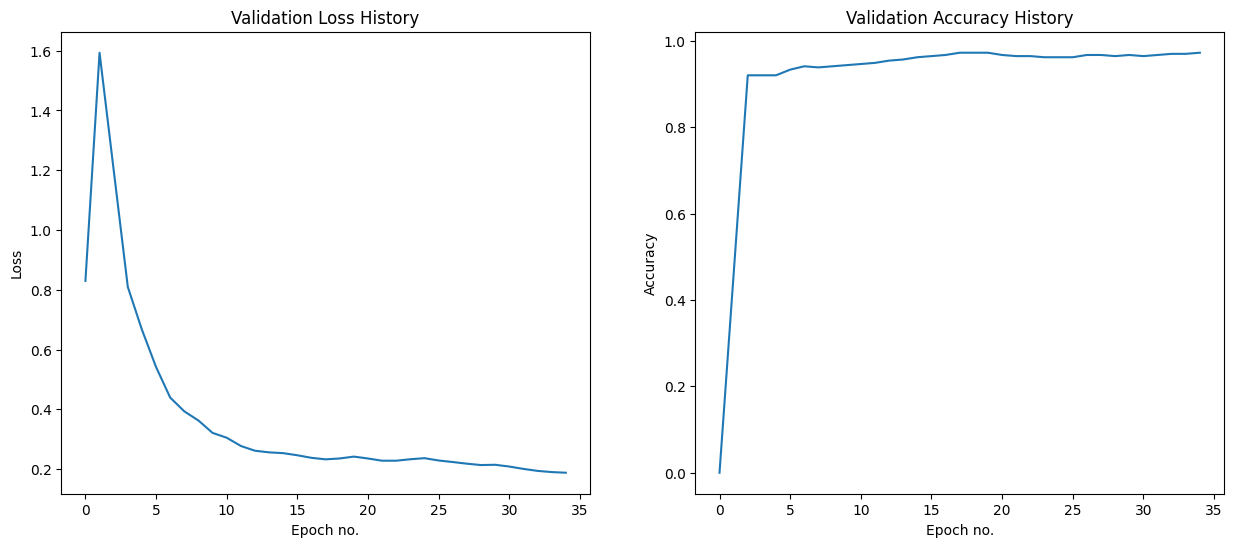

In [40]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(smooth(loss_history, 2)[:-2], label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')


ax[1].plot(smooth(acc_history, 2)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')
plt.show()

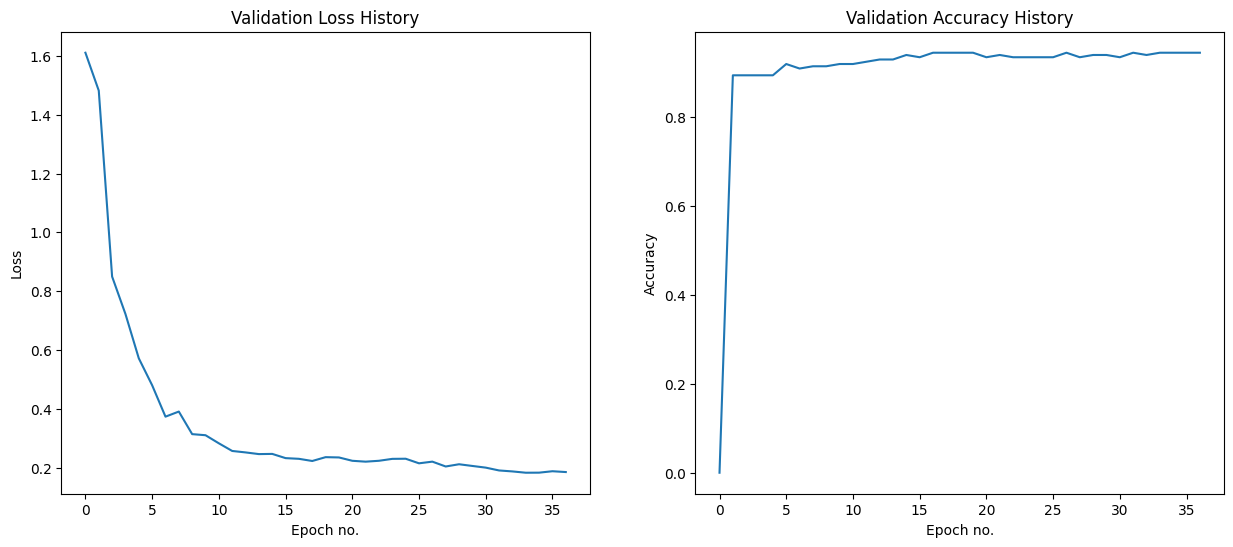

In [41]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')

ax[1].plot(acc_history, label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy')
plt.show()

In [42]:
test_results = []
labels= []
model.load_state_dict(torch.load('best.pth'))
model.eval()
for x_raw, x_fft, label in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

y_pred = []
y_true = []
model.load_state_dict(torch.load('best.pth'))
model.eval()

for x_raw, x_fft, labels in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    y_pred.extend(y_hat.tolist())
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth


# constant for classes

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_matrix
df_cm=pd.DataFrame(cf_matrix)
df_cm

,0,1,2,3
0,175,0,1,0
1,2,3,0,0
2,4,0,8,0
3,4,0,0,0


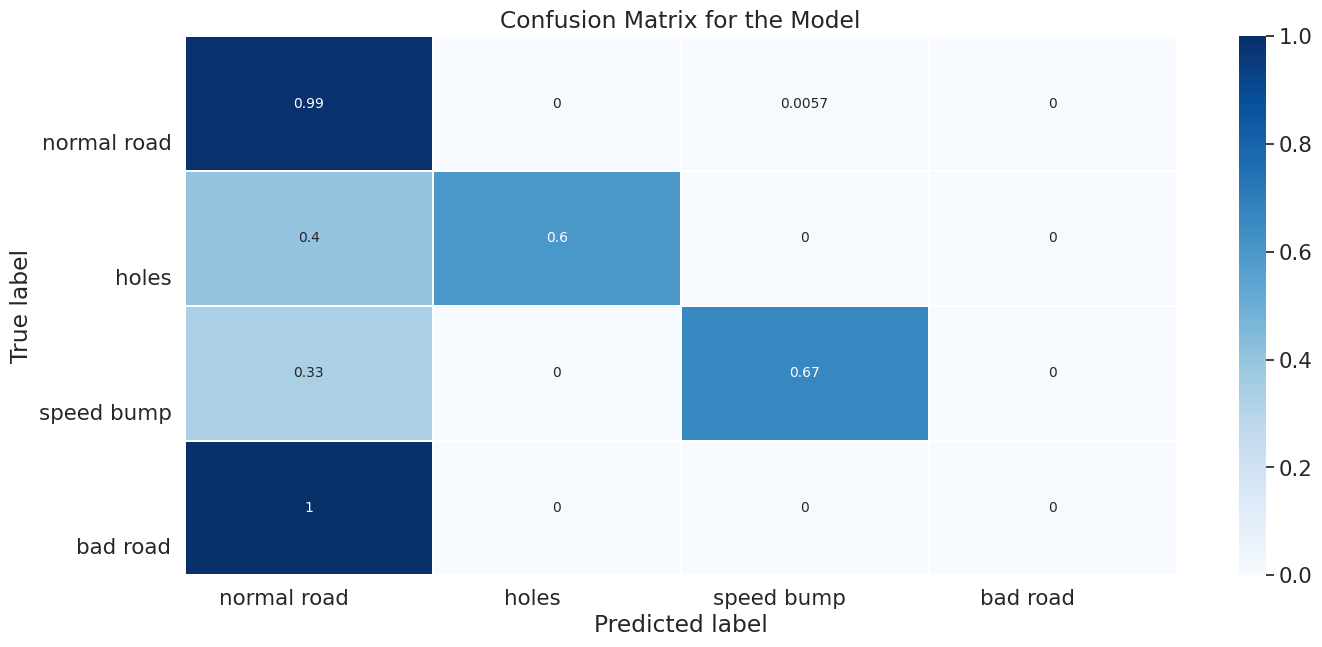

In [44]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_true, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['normal road', 'holes', 'speed bump',
               'bad road']
tick_marks = np.arange(4)+ 0.4
tick_marks2 = tick_marks + 0.4
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for the Model')
plt.show()

In [45]:
from sklearn.metrics import classification_report

print(    classification_report(y_true, y_pred)      )

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       176
           2       1.00      0.60      0.75         5
           3       0.89      0.67      0.76        12
           4       0.00      0.00      0.00         4

    accuracy                           0.94       197
   macro avg       0.71      0.57      0.62       197
weighted avg       0.92      0.94      0.93       197



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [46]:
torch.save(model.state_dict(), "DSC-BiLSTM_model.pth")

